In [1]:
import torch
from basic_unet import UNet
from testnet import TestnetDataset
from plot_utils import plot_image_row
from torchvision import transforms
from pathlib import Path
import hdm
from sklearn.metrics import mean_squared_error

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=1, out_channels=1)
state_dict = torch.load('models/2_testnet_0490.pth')
model.load_state_dict(state_dict)
model = model.to(device)
transform = transforms.Compose([
    transforms.Normalize([0.5, 0.5, 0.5, 0.5], [0.5, 0.5, 0.5, 0.5])
])
dataset = TestnetDataset(Path('testnet'), transform)

In [3]:
class DistanceMasks(hdm.HausdorffDistanceMasks):
    def calculate_distance(self, image1, image2):
        return mean_squared_error(image1, image2)

In [4]:
explainer = DistanceMasks(240, 240)
explainer.generate_masks(circle_size=15, offset=5, normalize=False)

In [5]:
def evaluate_plot(sample):
    segment = sample['segment']
    image = sample['input']
    result = explainer.explain(model, image, segment, device)

    raw = result.circle_map(hdm.RAW)
    absolute = result.circle_map(hdm.ABSOLUTE)
    better = result.circle_map(hdm.BETTER_ONLY)
    worse = result.circle_map(hdm.WORSE_ONLY)

    plot_image_row(
        image,
        title='Raw',
        color_map='gray',
        overlay=raw,
        overlay_alpha=0.9,
    )
    plot_image_row(
        image,
        title='Absolute',
        color_map='gray',
        overlay=absolute,
        overlay_alpha=0.9,
    )
    plot_image_row(
        image,
        title='Better (when this region is occluded, result is better)',
        color_map='gray',
        overlay=better,
        overlay_alpha=0.9,
    )
    plot_image_row(
        image,
        title='Worse (when this region is occluded, result is worse)',
        color_map='gray',
        overlay=worse,
        overlay_alpha=0.9,
    )

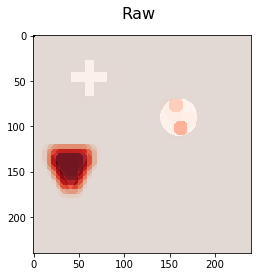

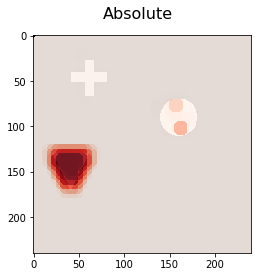

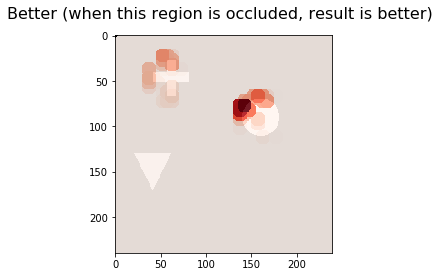

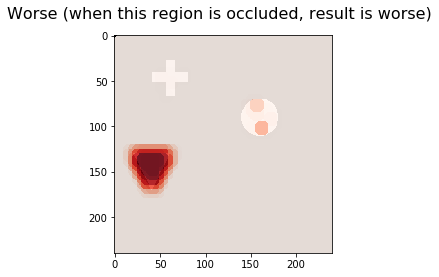

In [6]:
evaluate_plot(dataset.get_sample('0'))

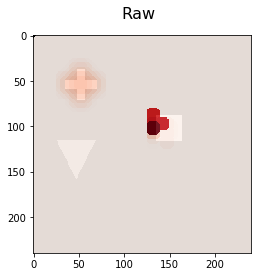

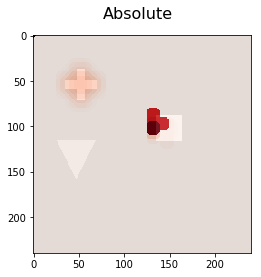

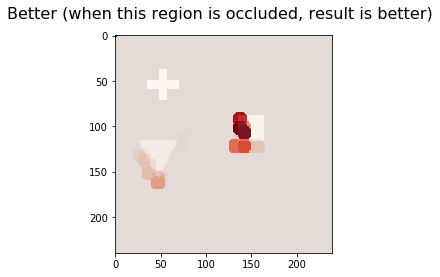

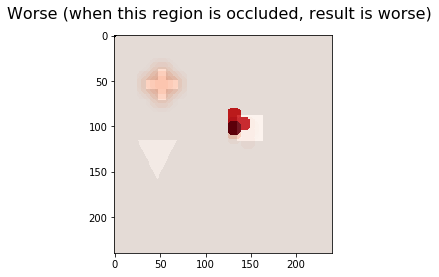

In [7]:
evaluate_plot(dataset.get_sample('1'))

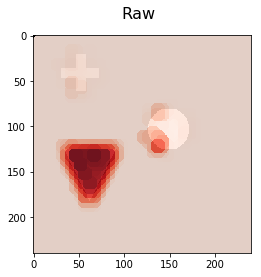

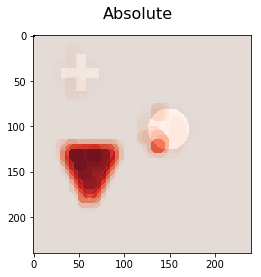

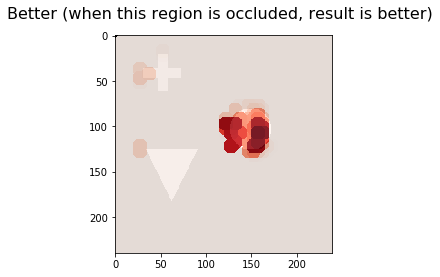

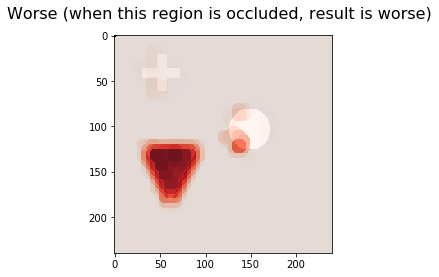

In [8]:
evaluate_plot(dataset.get_sample('2'))